In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Environment import Environment, MRP, MDP 
import utils as u

sns.set_theme(font_scale = 0.7)
sns.set_style()

Notes
'The environment obeys the laws/symmetries of the gridworld, but keeps track of everything thats in it, including the agents, thus this is what the agent interacts with '
    """
    Maybe also internal dynamics: t increments are environment steps, additionally
    Since the environment is markov it is not necessary to keep explicit track of the history

    Interaction:
        Gets:
        Action agent At
    
        Emits:
        Observation Ot+1 (= St+1 in fully obserable MDP)
        Reward Rt+1

    Note that this also entails that the t-increments happen at the environment steps

### Initialization and set-up

In [2]:
# Characteristics of grid world
width, height = 5, 5 #Gridworld 

#Add inaccessible or absorbing states -> not yet for the purposes of this notebook
obstacle_states = [[11, 12, 13]] 
absorbing_state = []

#set-up environment
env = Environment(width, height)
env.add_forbidden_states([obstacle_states])
env.add_absorbing_states([absorbing_state])

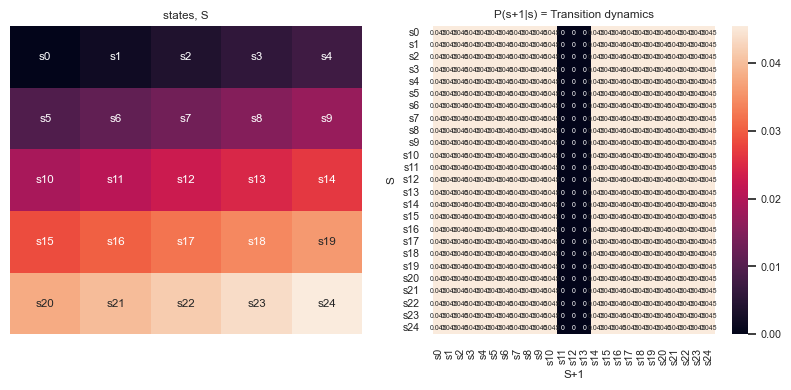

In [3]:
# visualise environment
fig, ax = plt.subplots(1, 2, figsize = (10,4))
plt.sca(ax[0])
plt.title('states, S')
env.plot_grid() 
plt.sca(ax[1])
env.plot_dynamics() 
plt.show()

### Markov Process (S, P)

In [4]:
def markov_chain(env, start_state, n = 100):

    # Initialize
    next_state = start_state 
    t = 0
    t_end = n

    # Bookkeeping
    trajectory = [env.states[start_state]] #Trajectory states

    # Step through environment
    while (t != t_end-1):
    
        current_state = next_state #St
        t +=1 #step
        next_state = int(np.random.choice(env.states_id, p = env.P[current_state]))  #St+1

        # Bookkeeping
        trajectory.append(f'{env.states[next_state]}')

    return np.array(trajectory).T

In [5]:
trajectory = markov_chain(env, start_state = 0, n = 10)
print(f'Trajectory: {trajectory}')

Trajectory: ['s0' 's18' 's21' 's6' 's6' 's8' 's1' 's18' 's4' 's17']


### Markov Reward Process (S, P, R, gamma)

#### Initialization

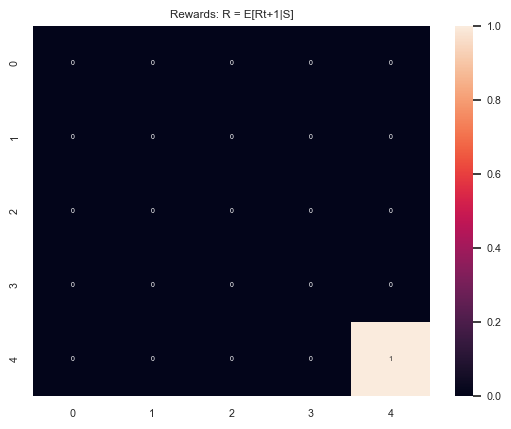

In [6]:
# Create environment
gamma = 0.9 #discount factor
env = MRP(width = width, height = height, gamma = gamma) #create environment

#set rewards
goal_state = 24
R = 1 
penalty = 0 #can add penalty, be aware of reward shaping
env.set_rewards(goal_state, goal_reward = R, penalty_steps = penalty)

# Visualize rewards
env.plot_rewards()
plt.show()

In [7]:
def markov_reward_process(env, start_state, n = 100):
    # Initialize
    next_state = start_state 
    t = 0
    t_end = n 
        
    # Bookkeeping 
    Gt = 0 #Return 

    # Step through environment
    while (t != t_end):
        current_state = int(next_state) # St
        t+=1 # step
        reward = env.reward_function(current_state) # Rt+1 
        next_state = np.random.choice(env.states_id, p = env.P[current_state]) # St+1

        # Bookkeeping
        Gt += (env.gamma**(t-1)) * reward  #Keep track of discounted rewards
    return Gt 
 

In [8]:
#MRP
Gt = markov_reward_process(env, start_state = 0, n = 100)
print(f'Gt (Return): {Gt}')

Gt (Return): 0.15205693214312713


#### Value function: v(s) = E[Gt|St = s]

In [9]:
def state_value_function(env, start_state, episodes = 100, n = 100):
    cumulative_returns = 0
    for i in range(episodes): #loop through episodes
        cumulative_returns = cumulative_returns + markov_reward_process(env, n = n, start_state = start_state) 
    state_value = cumulative_returns/episodes
    return state_value

In [10]:
start_state = 0
state_value = state_value_function(env, start_state = start_state, episodes = 100, n = 100)
print(f'E[Gt|St = {start_state}]: {state_value}')

E[Gt|St = 0]: 0.3910456282616371


#### Bellman expectation equation (Tree search & Matrix)

In [11]:
# Tree search MRP's: v(s) = E[Rt+1 + gamma * v(s') |St = s]
state_values = np.zeros(env.nstates)
for i in range(env.nstates): #loop over all starting_states
    state_value = state_value_function(env, start_state = i, episodes = 100, n = 100)
    state_values[i] = state_value
print(env.fit_grid(state_values))

# v(s) = Rs + gamma * sum_over_successor_states(Pss'v(s')): 
state = 4
immediate_reward = env.reward_function(state) #Rs
gamma = gamma
p = env.P[state] #Pss'
v_successors = state_values #v(s')

#check
v_state = immediate_reward + gamma * np.sum(p * v_successors)
print(f'Bellmann v(s = {state}): {v_state}')

[[0.39317826 0.3510254  0.37510129 0.36652975 0.34708542]
 [0.34948976 0.28942799 0.34418738 0.23794588 0.34888972]
 [0.26067483 0.32358296 0.40915637 0.38722602 0.38635406]
 [0.36911917 0.37349869 0.4307055  0.4111813  0.36658878]
 [0.34782074 0.35691359 0.31402673 0.30188837 1.36736793]]
Bellmann v(s = 4): 0.35312277183693774


In [12]:
# Solving Bellmann expectation in matrix form
values = np.linalg.inv((np.identity(env.nstates) - (env.gamma * env.P))) @ env.R.T
print(env.fit_grid(values))

[[0.36 0.36 0.36 0.36 0.36]
 [0.36 0.36 0.36 0.36 0.36]
 [0.36 0.36 0.36 0.36 0.36]
 [0.36 0.36 0.36 0.36 0.36]
 [0.36 0.36 0.36 0.36 1.36]]


### Markov Decision Process, fully observable (S, P[s'|s,a], R(s,a), A, gamma)

#### Initialization and set-up

In [13]:
start_state = 0
width, height = 5, 5
gamma = 0.9
goal_state = 4
env = MDP(width = width, height = height, gamma = gamma)
env.set_rewards(goal_state)

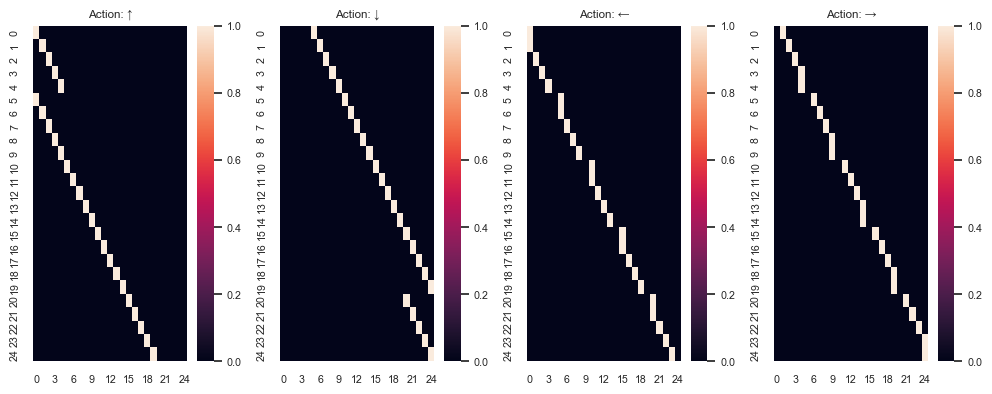

In [14]:
fig, ax = plt.subplots(1, 4, figsize = (10,4))
for i in range(env.agent.n_actions):
    plt.sca(ax[i])
    plt.title(f'Action: {env.agent.actions.get(i)[1]}')
    sns.heatmap(env.P[i])
plt.tight_layout()
plt.show()

In [15]:
def markov_decision_process(env, start_state, n = 100):
    next_state = start_state
    t, t_end = 0, n #time horizon

    #Bookkeeping
    env.agent.Gt = 0 #return
    trajectory = [env.states.get(start_state)] #keep track of location, just for visualisation, don't use
    fig = env.render(start_state, env.map, title = f'Gt: {env.agent.Gt}')

    #Step through environment
    while (t != t_end-1):
        current_state = next_state #St
        #Agent receives reward and state
        action = env.agent.step(current_state, policy = env.agent.policy) #Agent picks an action
        t+=1 #step
        reward = env.R[action][int(current_state)] #Rt+1
        dynamics = env.dynamics_environment(state = current_state, action = action)[3]

        next_state = np.random.choice(env.nstates, p = dynamics) #St+1
            

        #Bookkeeping
        fig = env.render(next_state, env.map, title = f'Gt: {env.agent.Gt}')
        plt.close(fig)
        
        env.agent.Gt += (env.gamma ** (t-1) * reward)
        trajectory.append(f'{env.states.get(next_state)}')

    return env.agent.Gt, print(f'Return (Gt): {env.agent.Gt} \nTrajectory: {np.array(trajectory).T}')

Return (Gt): 0.002738927449953412 
Trajectory: ['s0' 's5' 's6' 's1' 's2' 's7' 's6' 's5' 's10' 's10' 's11' 's6' 's5' 's0'
 's1' 's1' 's0' 's5' 's5' 's5' 's10' 's11' 's16' 's21' 's22' 's23' 's24'
 's24' 's24' 's24' 's23' 's22' 's22' 's22' 's17' 's22' 's17' 's22' 's22'
 's22' 's21' 's20' 's21' 's20' 's20' 's20' 's15' 's15' 's10' 's11' 's6'
 's1' 's1' 's1' 's2' 's3' 's4' 's3' 's2' 's1' 's1' 's6' 's5' 's6' 's7'
 's6' 's5' 's6' 's1' 's6' 's5' 's10' 's10' 's11' 's6' 's5' 's6' 's11' 's6'
 's7' 's8' 's13' 's14' 's19' 's18' 's23' 's24' 's19' 's19' 's14' 's13'
 's14' 's14' 's14' 's9' 's9' 's14' 's9' 's14' 's13']


(0.002738927449953412, None)

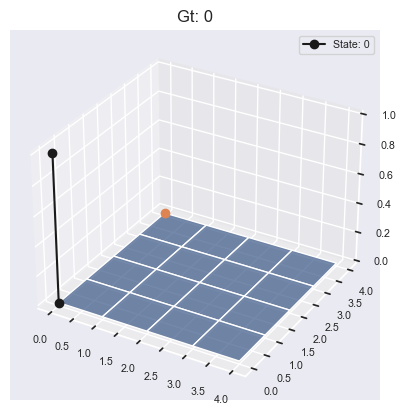

In [16]:
# Check dynamics
markov_decision_process(env = env, start_state= 0)

#### Some formalism

In [ ]:
#3.1: p(s', r|s, a)
action = np.random.choice(env.agent.n_actions)
state = np.random.choice(env.nstates)
env.P # #p(s', s)
env.P[0] #P(s'|s)
a, b, c, transition_probs = env.dynamics_environment(state = state, action = action) #p(s',r|s,a), p(s'|s, a), (3,2)
next_state = np.random.choice(env.nstates, p = transition_probs)
print(f'St: {state}, At: {action} \nSt+1: {next_state}')
print(f'r(s,a):\n{env.R}') #r(s,a)


St: 10, At: 2 
St+1: 10
r(s,a):
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


In [ ]:
print(f'(3.3): {np.sum(a)}') 
print(f'(3.4): {np.sum(a, axis = 1)}')  #p(s'|s,a)
print(f'(3.5) {env.reward_function(state = 0, action = 1)}')#3.5 -> can not directly get it from a, since the values are inaccurate, if you look at the code, you'll see the successor states weighting the rewards and getting the dot product
print(f'3.6 {env.reward_function(state = state, action = action)}')# r(s, a, s')


(3.3): 1.0
(3.4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3.5) 0.0
3.6 0.0


#### Policies

In [ ]:
# Sum_a P(s'|s, a) * policy(a|s), from policies (2), average next state over policy
def transition_pi(env, state, pi):
        p_matrix = np.zeros((env.nstates))
        for i in range(env.agent.n_actions):
            p_matrix += env.dynamics_environment(state = state, action = i)[3] * pi[state][i] #env.agent.policy[state][i]
        return p_matrix

#R(s,pi), from policies (2), average reward over policy
def reward_pi(env, state, pi):
    rewards = 0
    for a in range(env.agent.n_actions):
        rewards += env.R[a][state] * pi[state][a] #nv.agent.policy[state][i]
    return rewards

In [ ]:
pi = env.agent.policy
print(transition_pi(env, state = 10, pi = env.agent.policy))
print(reward_pi(env, state = 5, pi = env.agent.policy))

[0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.25 0.25 0.   0.
 0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
0.0


#### State values MDP

In [ ]:
#value function, monte carlo
def markov_decision_process(env, start_state, n = 100):
    next_state = start_state
    t, t_end = 0, n #time horizon

    #Bookkeeping
    env.agent.Gt = 0 #return

    #Step through environment
    while (t != t_end-1):
        current_state = next_state #St
        #Agent receives reward and state
        action = env.agent.step(current_state) #Agent picks an action
        t+=1 #step
        reward = env.R[action][int(current_state)] #Rt+1
        dynamics = env.dynamics_environment(state = current_state, action = action)[3]

        next_state = np.random.choice(env.nstates, p = dynamics) #St+1
        
        #Bookkeeping
        env.agent.Gt += (env.gamma ** (t-1) * reward)

    return env.agent.Gt

def state_value_function(env, start_state, episodes = 100, n = 100):
    cumulative_returns = 0
    for i in range(episodes): #loop through episodes
        cumulative_returns = cumulative_returns + markov_decision_process(env, n = n, start_state = start_state) 
    state_value = cumulative_returns/episodes
    return state_value

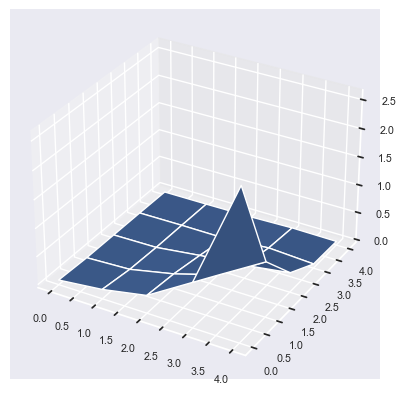

In [ ]:
state_values = np.zeros(env.nstates)
for i in range(env.nstates): #loop over all starting_states
    state_value = state_value_function(env, start_state = i, episodes = 100, n = 10)
    state_values[i] = state_value
env.plot_landscape(state_values)

#### Action-value function

In [ ]:
def q_value(env, start_state, start_action, n = 100):
        # Initialize
        next_state = start_state
        terminate = False
        t = 0
        t_end = n # time horizon

        #Bookkeeping
        Gt = 0 #return

        #first step based on starting action
        current_state = next_state #St
        #Agent receives reward and state
        action = start_action #Agent picks an action
        t+=1 #step
        reward = env.R[action][current_state] #Rt+1
        next_state = np.random.choice(env.states_id, p = env.dynamics_environment(state = current_state, action = action)[3]) #St+1

        #Bookkeeping
        Gt += (env.gamma ** (t-1) * reward)

        #Step through environment
        while (t != t_end-1 and not terminate):
            current_state = next_state #St
            #Agent receives reward and state
            action = env.agent.step(current_state) #Agent picks an action
            t+=1 #step
            reward = env.R[action][current_state] #Rt+1
            next_state = np.random.choice(env.states_id, p = env.dynamics_environment(state = current_state, action = action)[3]) #St+1

            #Bookkeeping
            Gt += (gamma ** (t-1) * reward)
        return Gt

def state_action_value(env, start_state, start_action, episodes = 100, n = 100):
    #loop through episodes
    state_returns = 0
    for i in range(episodes):
        #Cumulate Gt
        state_returns = state_returns + q_value(env, n = n, start_state = start_state, start_action = start_action)
            
    # State value = E(gt | st = start_state)
    state_value = state_returns/episodes
    return state_value

In [ ]:
#action value function, monte carlo
q_value(env, start_state = 8, start_action = 3)

6.922723989906217e-05

In [ ]:
state_action_value(env, start_state = 5, start_action = 3)

0.13185239198433726

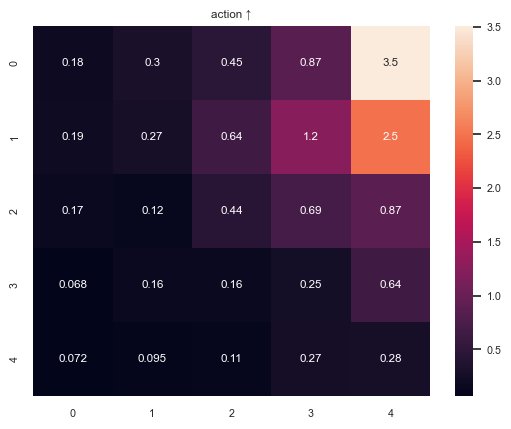

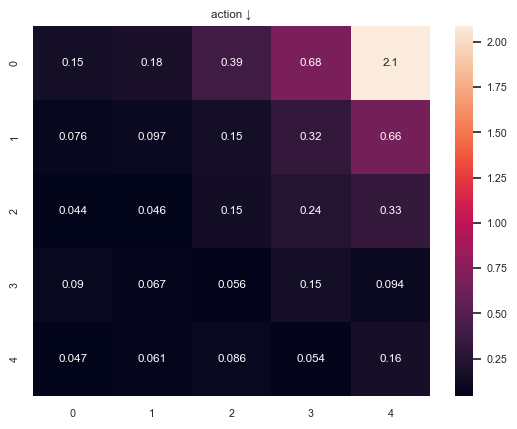

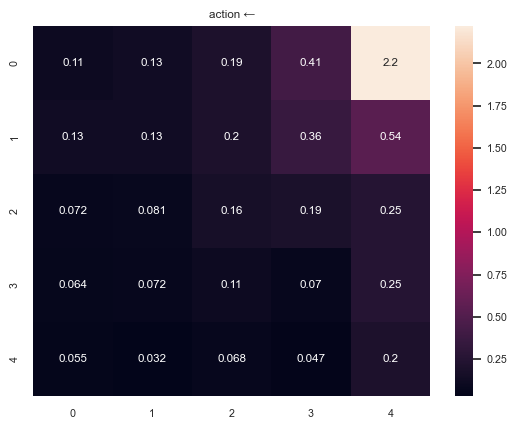

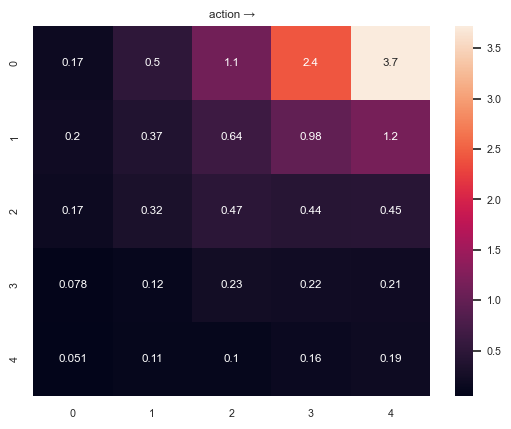

In [ ]:
q_values = np.zeros((env.agent.n_actions, env.nstates))
for i in range(env.agent.n_actions): #loop actions
    for j in range(env.nstates): #loop states
        q_values[i][j] = state_action_value(env, start_state = j, start_action = i, episodes = 100, n = 100)
    env.heatmap(q_values[i])
    plt.title(f'action {env.agent.actions.get(i)[1]}')
    plt.show()

In [ ]:
env.agent.policy = np.ones((env.nstates, env.agent.n_actions)) * 0.25
p_pi = np.zeros((env.nstates, env.nstates))
for i in range(env.nstates):
    p_pi[i] = transition_pi(env = env, state = i, pi = env.agent.policy)

r_pi = np.zeros((env.nstates))
for i in range(env.nstates):
    r_pi[i] = reward_pi(env = env, state = i, pi = env.agent.policy)

In [ ]:
#bellmann policy: random policy
values = np.linalg.inv((np.identity(env.nstates) - (env.gamma * p_pi))) @ r_pi.T
print(env.fit_grid(values))

[[0.1582304  0.25290899 0.51202224 1.14612661 2.75592177]
 [0.13387643 0.20087831 0.36459656 0.67982543 1.14612661]
 [0.10202122 0.14141053 0.22770319 0.36459656 0.51202224]
 [0.07611947 0.0978885  0.14141053 0.20087831 0.25290899]
 [0.06227957 0.07611947 0.10202122 0.13387643 0.1582304 ]]


In [ ]:
# Monte carlo optimal policy 
policy = env.agent.policy
policies = []
for state in range(env.nstates):
    best_action = np.argmax(q_values[:, state])
    policy[state] = u.one_hot(best_action, env.agent.n_actions)
    policies.append(env.agent.actions.get(np.argmax(policy[state]))[1])
print(env.fit_grid(np.array(policies)))

[['↑' '→' '→' '→' '→']
 ['→' '→' '→' '↑' '↑']
 ['→' '→' '→' '↑' '↑']
 ['↓' '↑' '→' '↑' '↑']
 ['↑' '→' '↑' '↑' '↑']]
